# Assignment 3
# Part I: Windows-based stereo $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\longleftarrow 70\;pts$

In [3]:
%matplotlib inline

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
from matplotlib.colors import LogNorm
from skimage import img_as_ubyte
from skimage.color import rgb2gray

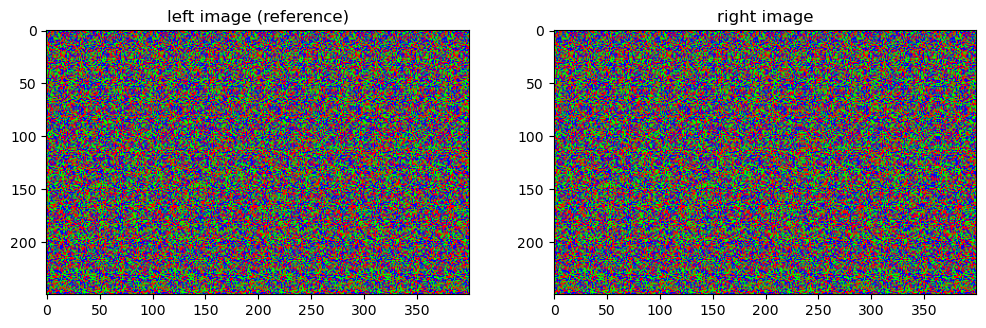

In [5]:
# you should use this random dot stereo pair for code developing/testing in Probelms 1-5
im_left = image.imread("images/stereo_pairs/rds_left.gif")
im_right = image.imread("images/stereo_pairs/rds_right.gif")

fig = plt.figure(figsize = (12, 5))
plt.subplot(121)
plt.title("left image (reference)")
plt.imshow(im_left)
plt.subplot(122)
plt.title("right image")
plt.imshow(im_right)

# the range of disparities for this random dot stereo pair 
d_min = 0
d_max = 2

### Problem 1: compute and visualize (as an image) an array of "squared differences" between RGB pixel values in the left and the right images. Treat each RGB pixel value as 3-vector and interprete "squared difference" as squared L2 norm of the difference between the corresponding vectors. 
###  HINT (important here and later): <font color=red> convert R, G, B values to floats to avoid severe "overflow" bugs </font> while adding small-range types (one-byte for $char$) or subtracting unsigned types. Note that $imshow$ function can display (as an image) any 2D array of floats.

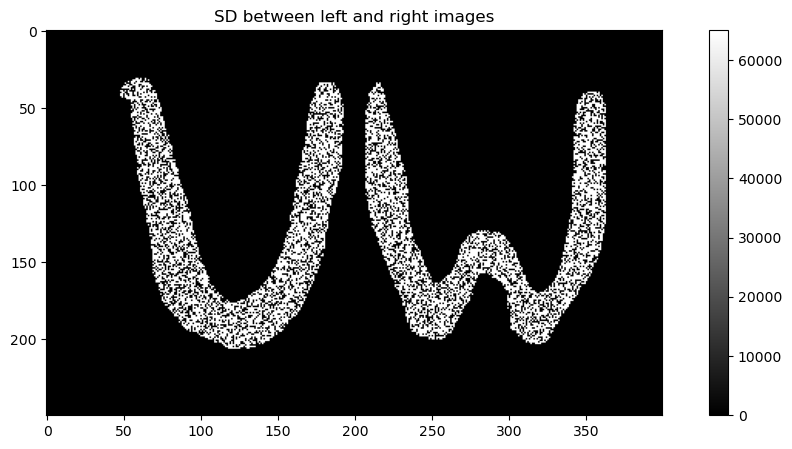

In [7]:
SD = np.zeros(np.shape(im_left))
SD = np.square(np.linalg.norm(x=(im_left-im_right).astype('float64'), ord=2, axis=2))

fig = plt.figure(figsize = (12, 5))
plt.title("SD between left and right images")
plt.imshow(SD, cmap = "gray")
plt.colorbar()

### Problem 2: write function for computing squared differences between RGB pixel values in the reference (left) image and the "shifted" right image for ALL shifts/disparities $\Delta$ in the range $\Delta\in [d_{min},d_{max}]$. You should think about the correct direction of the shift. The output should be array $SD$ such that $SD[i]$ is an image of Squared Differences for shift $\Delta = d_{min} + i$ for any $i\in [0,d_{max}-d_{min}]$. 

In [8]:
def SD_array(imageL, imageR, d_minimum, d_maximum):
    # initialization of the array of "squared differences" for different shifts
    SD = np.zeros((1+d_maximum-d_minimum,np.shape(imageL)[0],np.shape(imageL)[1]))

    for i in range(d_maximum-d_minimum+1):
        img = np.roll(a=imageR.astype('float64'), shift=d_minimum+i, axis=1)
        img[:, :d_minimum+i+1, :] = np.zeros(shape=img.shape[2])
        SD[i] = np.square(np.linalg.norm(x=(im_left-img).astype('float64'), ord=2, axis=2))
        
    return SD

### Use $\text{SD_array}$ function to compute SD images for the random dot stereo pair. Visualize such squared difference images for $\Delta=d_{min}$, $\Delta = d_{mid}\approx\frac{d_{min}+d_{max}}{2}$, and $\Delta=d_{max}$. Note that the first image should be identical to the one in Problem 1. (fully implemented)

(250, 400, 4)
(250, 400, 4)
(3, 250, 400)


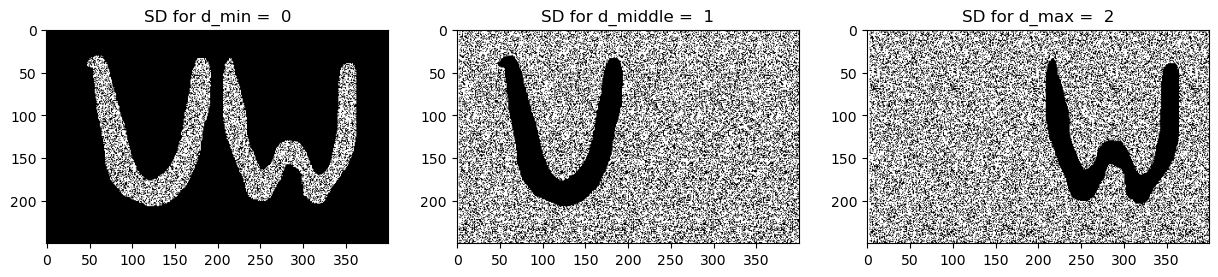

In [9]:
SD = SD_array(im_left, im_right, d_min, d_max) 
print(np.shape(im_left))
print(np.shape(im_right))
print(np.shape(SD))

fig = plt.figure(figsize = (15, 4))
plt.subplot(131)
plt.title('SD for d_min = {:>2d}'.format(d_min))
plt.imshow(SD[0], cmap = "gray")
plt.subplot(132) 
d_middle = round((d_min+d_max)/2)
plt.title('SD for d_middle = {:>2d}'.format(d_middle))
plt.imshow(SD[d_middle-d_min], cmap = "gray")
plt.subplot(133)
plt.title('SD for d_max = {:>2d}'.format(d_max))
plt.imshow(SD[d_max-d_min], cmap = "gray")
#plt.colorbar(cax=plt.axes([0.91, 0.25, 0.01, 0.5]))

### Problem 3: write function to compute an "integral image" for any given "scalar" image

In [10]:
# Function integral_image can be applied to any scalar 2D array/image. 
# This function should return a double/float64 (precision) array/image of the same size.
# NOTE: it is safer to explicitly specify double/float64 precision for integral images since 
# later we will be adding/subtracting ("differenting") their values in nearby pixels .

def integral_image(img):
    sum = np.cumsum(a=img.astype('float64'), axis=0)
    return np.cumsum(a=sum, axis=1)

### apply $\text{intergal_image}$ function to the "squared differences" (SD) for each disparity (fully implemented)

(3, 250, 400) (3, 250, 400)


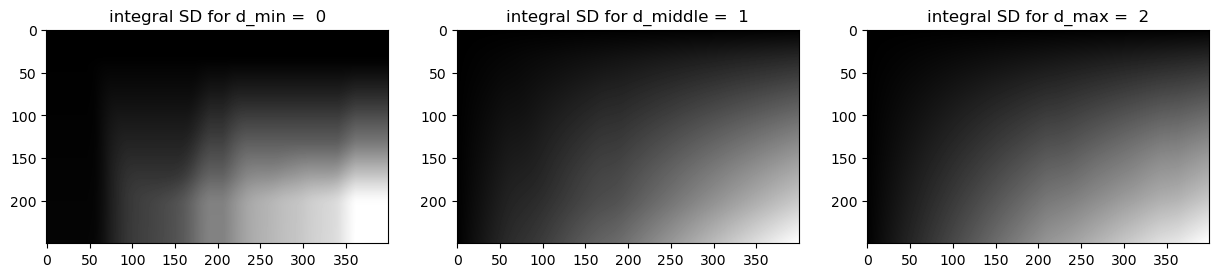

In [11]:
integral_SD = np.zeros(np.shape(SD))
print(np.shape(integral_SD),np.shape(SD))

for Delta in range(1+d_max-d_min):
    integral_SD[Delta] = integral_image(SD[Delta])
        
fig = plt.figure(figsize = (15, 4))
plt.subplot(131)
plt.title('integral SD for d_min = {:>2d}'.format(d_min))
plt.imshow(integral_SD[0], cmap = "gray")
plt.subplot(132) 
d_middle = round((d_min+d_max)/2)
plt.title('integral SD for d_middle = {:>2d}'.format(d_middle))
plt.imshow(integral_SD[d_middle-d_min], cmap = "gray")
plt.subplot(133)
plt.title('integral SD for d_max = {:>2d}'.format(d_max))
plt.imshow(integral_SD[d_max-d_min], cmap = "gray")
#plt.colorbar(cax=plt.axes([0.91, 0.2, 0.01, 0.6]))

### Problem 4: write function that sums the elements of the input image within fixed-size windows around image pixels. Note that this function should work for any (odd or even) values of parameter $\text{window_width}\in\{1,2,3,4,5,...\}$ according to the windows illustration below: <img src="images\windows.png">

In [13]:
# function windSum can be applied to any scalar 2D array/image. It should return an array/image where the value of 
# each element (pixel p) is the "sum" of the values in the input array/image within a window around element p.
# The return image should be of the same size/type and have its margins (around half-window width) filled with INFTY.
# NOTE: you should use function integral_image implemented earlier.
# HINT: you should use standard np.roll function to avoid double or triple for loops.
INFTY = np.inf

def windSum(img, window_width):
    int_img = integral_image(img)

    #Shifts wrt to p
    lr = int(np.floor(window_width/2)) # lower right
    ul = int(window_width - np.floor(window_width/2)) # upper left

    # Shift                           y-axis              x-axis            
    br = np.roll(a=np.roll(a=int_img, shift=-lr, axis=0), shift=-lr, axis=1)
    bl = np.roll(a=np.roll(a=int_img, shift=-lr, axis=0), shift=ul,  axis=1)
    tl = np.roll(a=np.roll(a=int_img, shift=ul,  axis=0), shift=ul,  axis=1)
    tr = np.roll(a=np.roll(a=int_img, shift=ul,  axis=0), shift=-lr, axis=1)
    
    wind_sum = br-bl+tl-tr

    wind_sum[-ul:lr+1, :] = INFTY
    wind_sum[:, -ul:lr+1] = INFTY

    # print(f"Window {window_width} lr {lr} ul {ul}")

    return wind_sum

### Compute SSD images for windows of different widths and for different disparities by applying $\text{windSum}$ function to the "squared differences" SD. Note that the results for windows of width 1 (the first row of the figure below) should look identical (except for the narrow "margin") to the results in Problem 2. (fully implemented)

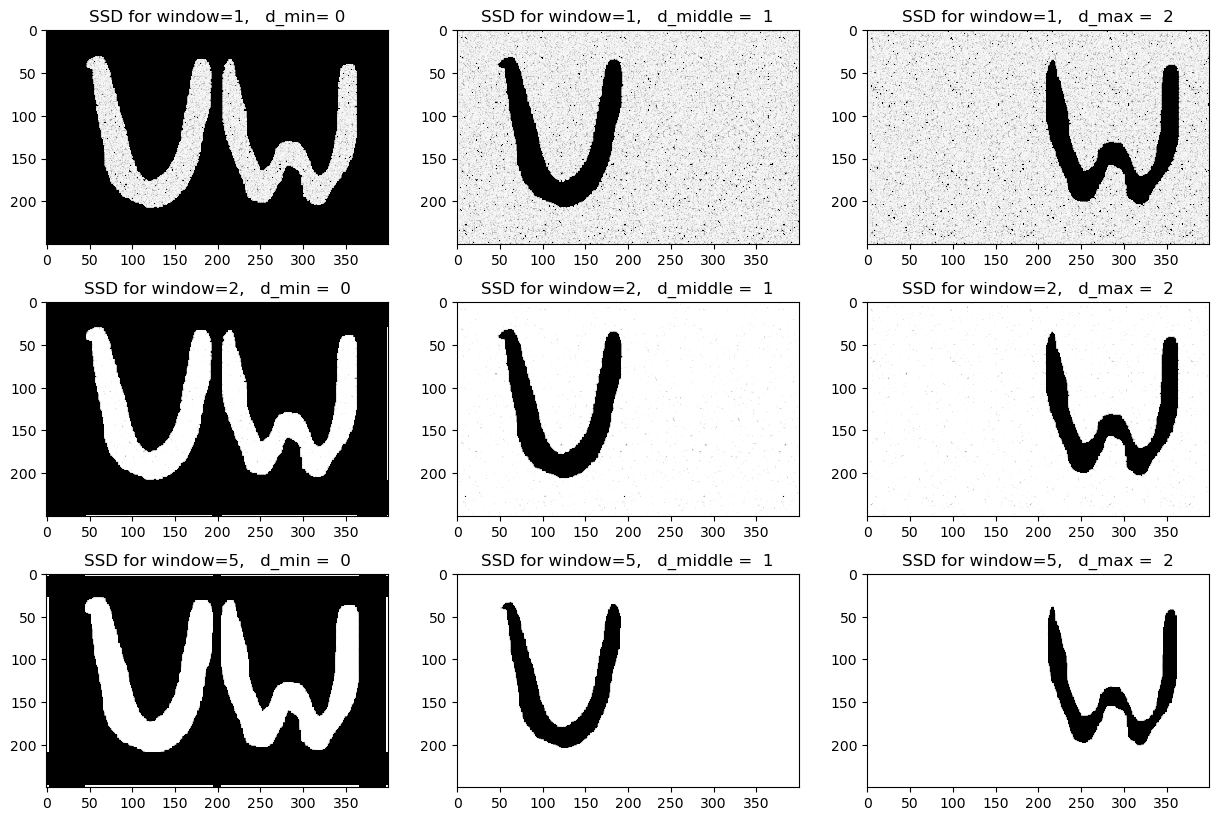

In [14]:
SSD1 = np.zeros(np.shape(SD))
SSD2 = np.zeros(np.shape(SD))
SSD5 = np.zeros(np.shape(SD))

for Delta in range(1+d_max-d_min):
    SSD1[Delta] = windSum(SD[Delta],1)
    SSD2[Delta] = windSum(SD[Delta],2)
    SSD5[Delta] = windSum(SD[Delta],5)
    
d_middle = round((d_min+d_max)/2)
        
fig = plt.figure(figsize = (15, 10))
plt.subplot(331)
plt.title('SSD for window=1,   d_min={:>2d}'.format(d_min))
plt.imshow(1+SSD1[0], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(332) 
plt.title('SSD for window=1,   d_middle = {:>2d}'.format(d_middle))
plt.imshow(1+SSD1[d_middle-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(333)
plt.title('SSD for window=1,   d_max = {:>2d}'.format(d_max))
plt.imshow(1+SSD1[d_max-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(334)
plt.title('SSD for window=2,   d_min = {:>2d}'.format(d_min))
plt.imshow(1+SSD2[0], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(335) 
plt.title('SSD for window=2,   d_middle = {:>2d}'.format(d_middle))
plt.imshow(1+SSD2[d_middle-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(336)
plt.title('SSD for window=2,   d_max = {:>2d}'.format(d_max))
plt.imshow(1+SSD2[d_max-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(337)
plt.title('SSD for window=5,   d_min = {:>2d}'.format(d_min))
plt.imshow(1+SSD5[0], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(338) 
plt.title('SSD for window=5,   d_middle = {:>2d}'.format(d_middle))
plt.imshow(1+SSD5[d_middle-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(339)
plt.title('SSD for window=5,   d_max = {:>2d}'.format(d_max))
plt.imshow(1+SSD5[d_max-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))

In [15]:
SSD1.shape

(3, 250, 400)

### Problem 5: write code for function computing "disparity map" from SSD arrays (as above) for each disparity in the range specified by integers $d_{min}$, $d_{max}$. It should return a disparity map (image). At each pixel, disparity map image should have disparity value corresponding to the minimum SSD at this pixel. For pixels at the margins, the disparity map should be set to zero. HINT: margin pixels are characterized by $INFTY$ values of $SSD$.

In [16]:
# You should use functions np.where (pointwise "if, then, else" operation) and np.minimum (pointwise "minimum" operation)
# These functions will help to avoid double loops for traversing the pixels.
# WARNING: there will be a deducton for double-loops traversing pixels, but single loop to traverse disparities is OK.

def SSDtoDmap(SSD_array, d_minimum, d_maximum):
    dMap = np.argmin(a=SSD_array, axis=0) + d_minimum
    
    return dMap

### Compute and show disparity map (fully implemented)

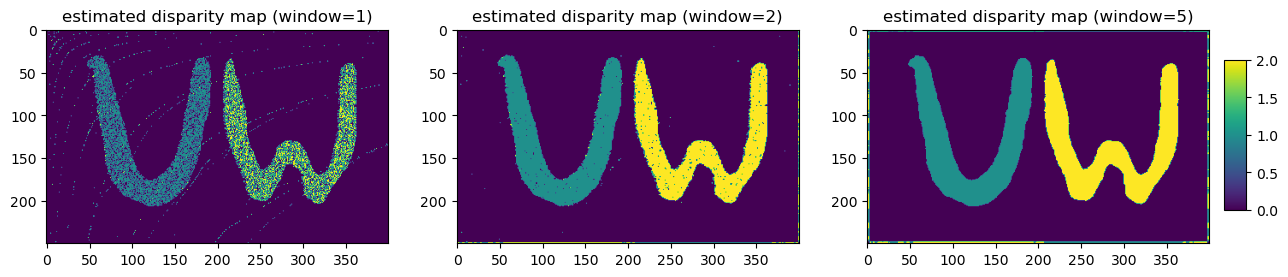

In [17]:
dMap1 = SSDtoDmap(SSD1,d_min,d_max)
dMap2 = SSDtoDmap(SSD2,d_min,d_max)
dMap5 = SSDtoDmap(SSD5,d_min,d_max)

fig = plt.figure(figsize = (15, 3))
plt.subplot(131)
plt.title("estimated disparity map (window=1)")
plt.imshow(dMap1, vmin = 0, vmax = d_max)
plt.subplot(132)
plt.title("estimated disparity map (window=2)")
plt.imshow(dMap2, vmin = 0, vmax = d_max)
plt.subplot(133)
plt.title("estimated disparity map (window=5)")
plt.imshow(dMap5, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.25, 0.015, 0.5]))

### Problem 6: test your code on a real stereo pair with ground truth (Tsukuba)

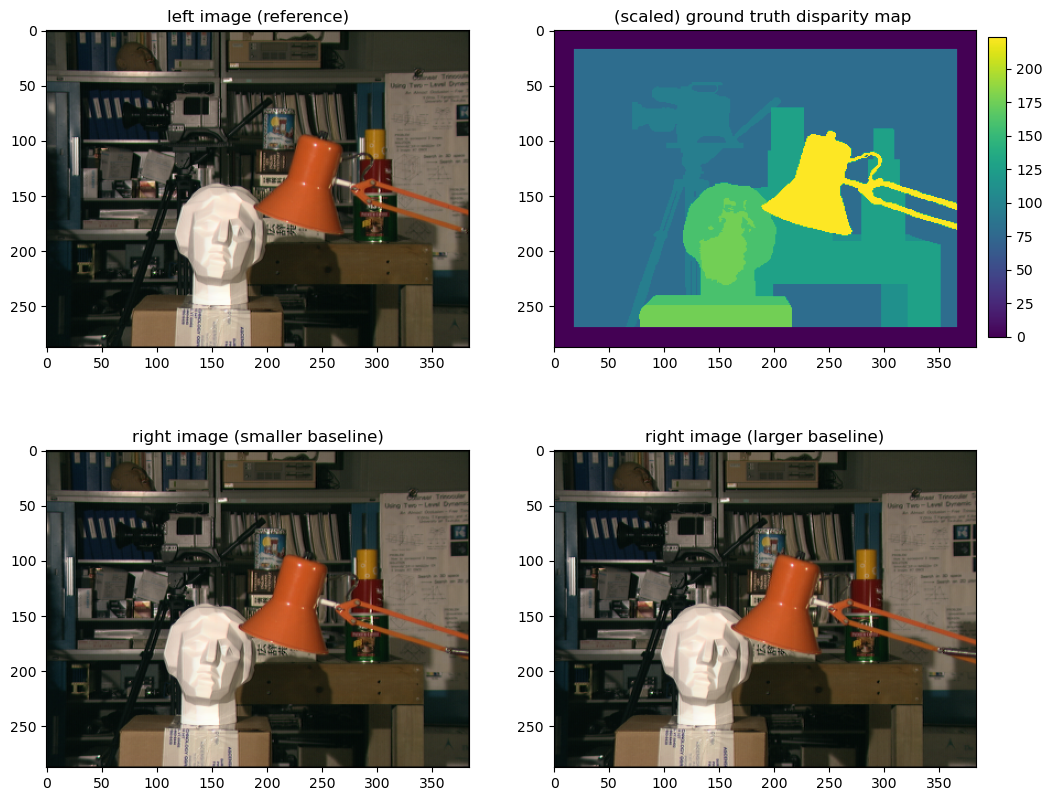

In [18]:
# images/tsukuba subdirectory contains (a subset of) "Tsukuba" stereo images that are probably 
# the oldest stereo data with dense ground-truth produced at the University of Tsukuba in 2001. 
# The full Tsukuba dataset and many other stereo images with ground-truth disparity maps can be
# downloaded from well-known Middlebury repository  http://vision.middlebury.edu/stereo/
im_left = image.imread("images/stereo_pairs/tsukuba/scene1.row3.col3.ppm")
im_gt = image.imread("images/stereo_pairs/tsukuba/truedisp.row3.col3.pgm")
im_right = image.imread("images/stereo_pairs/tsukuba/scene1.row3.col4.ppm")
im_right2 = image.imread("images/stereo_pairs/tsukuba/scene1.row3.col5.ppm")

fig = plt.figure(figsize = (12, 10))
plt.subplot(221)
plt.title("left image (reference)")
plt.imshow(im_left)
plt.subplot(222) 
plt.title("(scaled) ground truth disparity map ")
plt.imshow(im_gt)
plt.colorbar(cax=plt.axes([0.91, 0.557, 0.015, 0.3]))
plt.subplot(223)
plt.title("right image (smaller baseline)")
plt.imshow(im_right)
plt.subplot(224)
plt.title("right image (larger baseline)")
plt.imshow(im_right2)

### Note that the integer-valued ground truth image above represents scaled disparity values for the pixels in the reference (left) mage. The scale w.r.t. the smaller baseline right image im_right is 16 and for the larger baseline image im_right2 is 8. Below, you should use the smaller-baseline right image im_right. 

### Problem 6a: Using ground truth disparity map, estimate the range of disparity values between pixels in the left image im_left and the right image im_right.

In [19]:
# Solution: use standard functions to find min and max values in the ground truth disparity map. 
# You should ignore 0-valued margin!
print(np.unique(im_gt))
d_min = int(np.unique(im_gt)[1]/16) # change me
d_max = int(np.unique(im_gt)[-1]/16) # change me

[  0  80  96 112 128 160 176 224]


### Compute squared differences using SD_array function and visualize the results using logarithmic scale. Note that linear scale would make it hard to see smaller squared differences since there are many very large ones. (fully implemented)

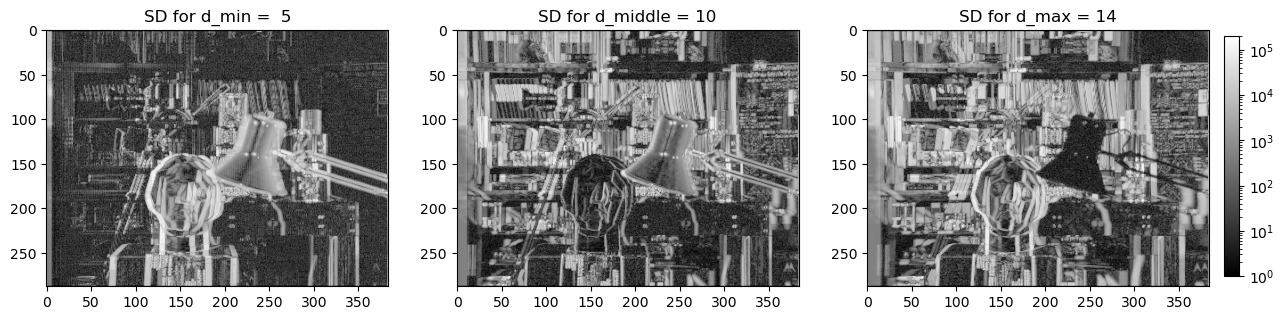

In [20]:
SD = SD_array(im_left, im_right, d_min, d_max)    
    
fig = plt.figure(figsize = (15, 4))
plt.subplot(131)
plt.title('SD for d_min = {:>2d}'.format(d_min))
plt.imshow(im_left)
plt.imshow(1+SD[0], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(132) 
d_middle = round((d_min+d_max)/2)
plt.title('SD for d_middle = {:>2d}'.format(d_middle))
plt.imshow(1+SD[d_middle-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(133)
plt.title('SD for d_max = {:>2d}'.format(d_max))
plt.imshow(1+SD[d_max-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.colorbar(cax=plt.axes([0.91, 0.2, 0.01, 0.6]))

### Problem 6b: Explain the differences you observe above:

answer: The purpose of the squared difference function is to identify the disparity of a given pixel by minimizing the squared difference between the left and right image via disparity. Hence, anytime the pixel is close to being black, that means the disparity for the object is at the given image. So for example, the disparity of the background is around d=5 because it is close to black. The disparity of the lamp is at or likely close to d=14 because the lamp is coloured black.

### Problem 6c: Write function {Dmap_Windows} that returns disparith map from a given stereo pair (left and right image), specified disparity range, and window size. Your implementation should combine functions implemented and debugged earlier ({SD_array}, {windSum}, and {SSDtoDmap}).

In [21]:
def Dmap_Windows(imageL, imageR, d_minimum, d_maximum, window_width):
    SD = SD_array(imageL, imageR, d_minimum, d_maximum)
    SSD = np.zeros(np.shape(SD))
    for i in range(d_max - d_min + 1):
        SSD[i] = windSum(SD[i], window_width)
    dMap = SSDtoDmap(SSD, d_minimum, d_maximum)

    
    return dMap

### Compute and show disparity maps for Tsukuba using small and large windows. (fully implemented)

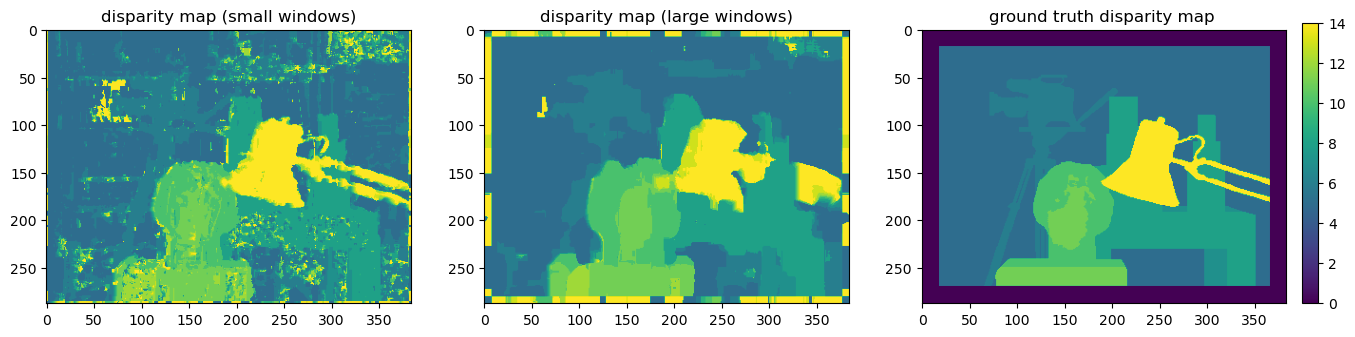

In [22]:
dispMap_small = Dmap_Windows(im_left, im_right, d_min, d_max, 4)
dispMap_large = Dmap_Windows(im_left, im_right, d_min, d_max, 15)

fig = plt.figure(figsize = (16, 7))
plt.subplot(131)
plt.title("disparity map (small windows)")
plt.imshow(dispMap_small, vmin = 0, vmax = d_max)
plt.subplot(132)
plt.title("disparity map (large windows)")
plt.imshow(dispMap_large, vmin = 0, vmax = d_max)
plt.subplot(133) 
plt.title("ground truth disparity map ")
plt.imshow(im_gt/16, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))

# Part II: Scan-line stereo   $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\longleftarrow 30\;pts$

### Problem 7(a):  Program $Viterbi$ approach discussed in class and apply it to Tsukuba example. For the photo-consistency term  of the loss function (objective function) you can use previously implemented {SD_array} $$D_p(d) = |I_p-I_{p+d}|^2 \;\;\;\;\;\longleftarrow\;\;\;\; {SD_array}[d][p] $$ that for every pixel $p$ defines the cost for every possible disparity value $d\in\{d_{min},...,d_{max}\}$. The regularization term should be $$V_{pq}(d_p,d_q) = w|d_p-d_q|$$ where you can select some value for parameter $w$ empirically (start from $w\approx 0$).  Discuss the differences with the results of the window-based stereo above.

### NOTE: You should implement $Viterbi$ optimization yourself - it was fully covered in class. Organize your code (e.g. add cells, introduce functions, write comments, ect) as part of your mark will depend on clarity. The main iteration of the forward pass in Viterbi ($m^2$-complexity operation for each pair of neighboring pixels on a scan-line) can be implemented as a separate function. You can avoid double for-loops using functions like  𝑛𝑝.𝑤ℎ𝑒𝑟𝑒 ,  𝑛𝑝.𝑚𝑖𝑛𝑖𝑚𝑢𝑚 ,  𝑛𝑝.𝑠𝑞𝑢𝑎𝑟𝑒 ,  𝑛𝑝.𝑜𝑔𝑟𝑖𝑑  or others similar general "vectorized" functions in numpy that alow to avoid multi-loops over matrix (image) elements (pixels).

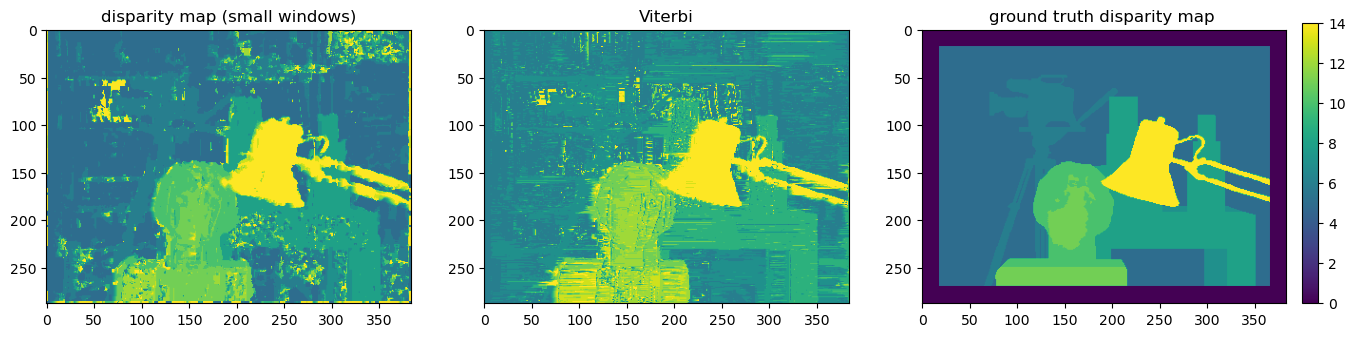

In [223]:
# For each disparity, construct the loss function
def get_cost_function_matrix(SD, d_min, d_max, w):
    d_vals = np.arange(d_min, d_max + 1)
    d = np.full((d_max - d_min + 1, d_max - d_min + 1), d_vals)
    V_pq = np.abs(d-d.T) * w
    V_pq_full = np.broadcast_to(array=V_pq, shape=(SD.shape[0], SD.shape[1], SD.shape[2], 10))
    E_pq = SD[:, :, :, np.newaxis] + V_pq_full
    return E_pq

def viterbi(im_left, im_right, d_min, d_max, w):
    SD = np.dstack(SD_array(im_left, im_right, d_min, d_max)) # disparity, im_y, im_x
    E_pq = get_cost_function_matrix(SD, d_min, d_max, w)

    E = np.zeros(shape=(d_max-d_min+1, SD.shape[0]))
    min_disp = np.zeros(shape=(SD.shape[1], d_max-d_min+1, SD.shape[0]))
    for col in range(SD.shape[1]):
         
         for disp in range(E_pq.shape[-1]):
            # Get the smallest cost for each pixels (in the column) disparity
            E[disp] = np.min(E_pq[:, col, :, disp], axis=1) + E[disp] 
            
            # Save the disparity which gave disp the smallest cost
            min_disp[col][disp] =np.argmin(E_pq[:, col, :, disp], axis=1)

    # Given the smallest cost, get its path    
    lowest_disp_ind = np.array((np.argmin(E, axis=0), np.arange(SD.shape[0])), dtype=int)
    disparities = [lowest_disp_ind[0]]
    for col in range(SD.shape[1]-1):
        disparities.append(min_disp[SD.shape[1]-2-col][ lowest_disp_ind[0], lowest_disp_ind[1]])
        lowest_disp_ind = np.array((min_disp[SD.shape[1]-2-col][lowest_disp_ind[0], lowest_disp_ind[1]], 
                                    np.arange(SD.shape[0])), dtype=int)

    return np.flip(np.array(disparities, dtype="float64").T, axis=1) + d_min

viterbi_img = viterbi(im_left, im_right, d_min, d_max, 15)

fig = plt.figure(figsize = (16, 7))
plt.subplot(131)
plt.title("disparity map (small windows)")
plt.imshow(dispMap_small, vmin = 0, vmax = d_max)
plt.subplot(132)
plt.title("Viterbi")
plt.imshow(viterbi_img, vmin = 0, vmax = d_max)
plt.subplot(133) 
plt.title("ground truth disparity map ")
plt.imshow(im_gt/16, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))



The figure above shows the disparity using small windows (since the windows one gave cleaner results ignoring the noise), the image using viterbi, and the ground truth disparity map. There is less noise in the Viterbi method however the viterbi algorithm seems to hardly notice smaller disparity differences, as the camera is not easily visible.

### Problem 7(b): Test the case where the photoconsistency term $D_p(d)$ is computed by averaging SD in some small window of size $h$. That is, for each disparity $d$ you should replace 2D array $SD_array(d)$ in Problem 7(a) by $$SD_array(d)   \;\;\;\;\;\longleftarrow\;\;\;\;  windSum(SD(d),h).$$ Compare the results for different window sizes $h\in\{1,3,5\}$. Feel free to fine tune regularization parameter $w$ for each case trying to obtain the best results possible. 
### NOTE 1: $h=1$ should be equivalent to Problem 7(a) above. 
### NOTE 2: this version combines window-based stereo with regularization along scan-lines. The case when $w=0$ should give the same results as in Problem 6(c).  

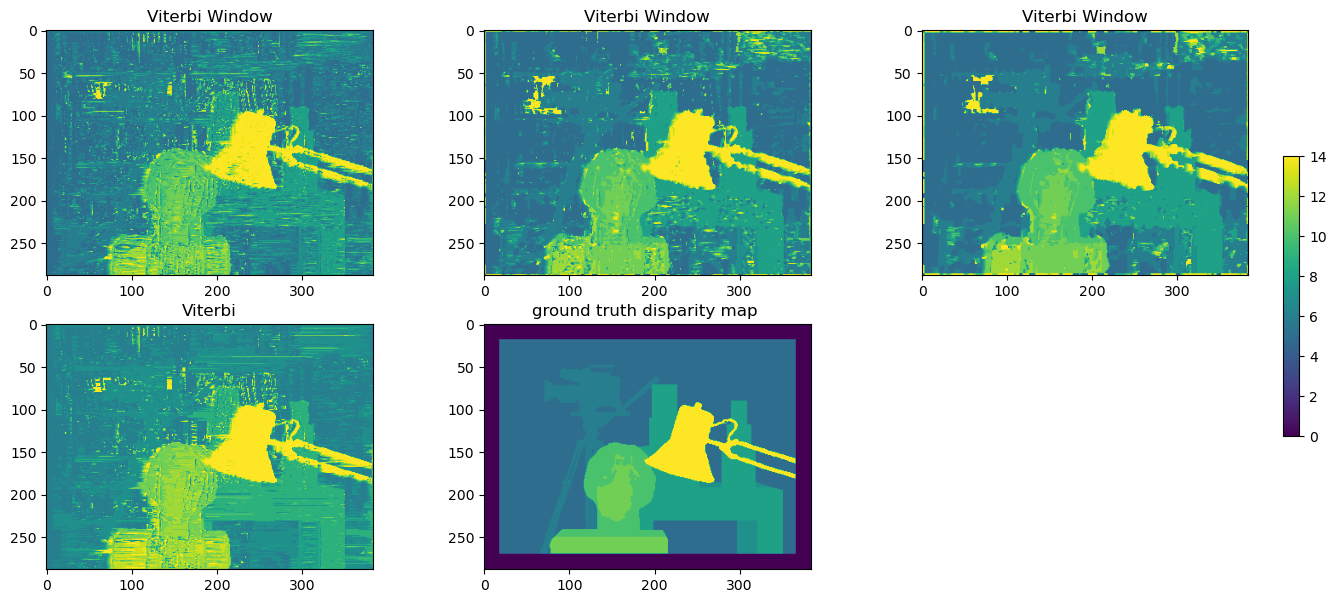

In [233]:
def get_window_SD(im_left, im_right, d_min, d_max, win):
    SD_temp = SD_array(im_left, im_right, d_min, d_max)
    SSD = np.zeros(np.shape(SD_temp))

    for Delta in range(1+d_max-d_min):
        SSD[Delta] = windSum(SD_temp[Delta],win)
    
    return SSD

def viterbi_window(im_left, im_right, d_min, d_max, w, win):
    SD = np.dstack(get_window_SD(im_left, im_right, d_min, d_max, win))
    E_pq = get_cost_function_matrix(SD, d_min, d_max, w)

    E = np.zeros(shape=(d_max-d_min+1, SD.shape[0]))
    min_disp = np.zeros(shape=(SD.shape[1], d_max-d_min+1, SD.shape[0]))
    for col in range(SD.shape[1]):
        
         for disp in range(E_pq.shape[-1]):
            # Get the smallest cost for each pixels (in the column) disparity
            E[disp] = np.min(E_pq[:, col, :, disp], axis=1) + E[disp]

            # Save the disparity which gave disp the smallest cost
            min_disp[col][disp] =np.argmin(E_pq[:, col, :, disp], axis=1)
    
    # Get path using the smallest cost  
    lowest_disp_ind = np.array((np.argmin(E, axis=0), np.arange(SD.shape[0])), dtype=int)
    disparities = [lowest_disp_ind[0]]
    for col in range(SD.shape[1]-1):
        disparities.append(min_disp[SD.shape[1]-2-col][ lowest_disp_ind[0], lowest_disp_ind[1]])
        lowest_disp_ind = np.array((min_disp[SD.shape[1]-2-col][ lowest_disp_ind[0], lowest_disp_ind[1]], 
                                    np.arange(SD.shape[0])), dtype=int)

    return np.flip(np.array(disparities, dtype="float64").T, axis=1) + d_min

viterbi_wind_1 = viterbi_window(im_left, im_right, d_min, d_max, 5, 1)
viterbi_wind_3 = viterbi_window(im_left, im_right, d_min, d_max, 5, 3)
viterbi_wind_5 = viterbi_window(im_left, im_right, d_min, d_max, 5, 5)

new_fig = plt.figure(figsize = (16, 7))
plt.subplot(231)
plt.title("Viterbi Window")
plt.imshow(viterbi_wind_1, vmin = 0, vmax = d_max)
plt.subplot(232)
plt.title("Viterbi Window")
plt.imshow(viterbi_wind_3, vmin = 0, vmax = d_max)
plt.subplot(233)
plt.title("Viterbi Window")
plt.imshow(viterbi_wind_5, vmin = 0, vmax = d_max)
plt.subplot(234)
plt.title("Viterbi")
plt.imshow(viterbi_img, vmin = 0, vmax = d_max)
plt.subplot(235) 
plt.title("ground truth disparity map ")
plt.imshow(im_gt/16, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))

With the increase in window size, the camera is more easily seen compared to the original Viterbi image. However, the bounding lines of the objects seem to blur more as the window size increased. It is essentially a tradeoff between the window size and level of accuracy.

#### The next problem 8 is required only for grad students. The undegrads can get a small bonus for this part.

### Problem 8 ("static cues" or aligning disparity boundaries to intensity edges): experiment with regularization weights $w_{pq}$ depending on a specific pair of neighboring points $\{p,q\}$ $$V_{pq}(d_p,d_q) = w_{pq}|d_p-d_q|$$ rather than all being equal to one constant $w_{pq}=w$, as in Problem 7. For such locally adaptive regularization weights $w_{pq}$ it is common to use local intensity contrast (in the reference image)  $$w_{pq}=w\exp\frac{-\|I_p-I_q\|^2}{2\sigma^2}$$ which weighs the overall regularization constant $w$ by a Gaussian kernel (see also slide 51, Topic 8). You should apply Gaussian kernel to RGB colors $I_p,I_q$ in the reference image. The Gaussian kernel weakens regularization near "contrast edges" making large disparity jumps cheaper at such "contrast edges" often observed at object boundaries. However, it can also weaken regularization in highly textured areas resulting in noisier disparity map. 
### Note that bandwith parameter $\sigma$ is very important as it controls sensitivity to contrast edges. It can be interpreted as a soft threshold for edge detection. Produce optimial disparity maps for scan-line stereo using different $\sigma$. For each $\sigma$ also visualize weights $w_{pq}$ for horizontal edges used in scan-line stereo (see slide 71 for an inspriration). For each $\sigma$ adjust the overall regularization weight $w$ to get the best result.